# 3. Decision trees
이번 시간에는 Decision tree에 대해 실습해 봅시다.

스무고개를 아시나요? 한 사람이 어떤 대상을 떠올리면, 다른 사람이 20개의 오직 예/아니오로만 대답할 수 있는 질문으로 그 대상을 알아맞히는 게임이죠.

Decision tree 방법 또한 스무고개와 비슷합니다. 

<b>컴퓨터에게 수많은 데이터와 라벨을 보여주고, 거기서 그 라벨들을 가장 잘 분류할 수 있는 기준(질문)을 찾게 하는 것입니다.</b>

이렇게 만들어진 decision tree는 새로운 데이터의 classification에 사용될 수 있습니다.

예를 들어 볼까요? 가상의 스팸 메일 분류기를 만들었다고 생각해 봅시다.

입력으로 메일의 내용과 그 분류 라벨("Email to read when bored", "Email from friends; read immediately", "Spam; dont' read")을 주면, 다음과 같은 decision tree를 출력합니다.

<img src="./img/3_1.jpg"></img>

이 결과로 우리는 어떤 분류 기준에 의해 각각의 class들이 분류되었는지 한눈에 알 수 있습니다. 이것이 decision tree의 장점입니다.

(반면 저번 시간에 다루었던 kNN의 경우는 어떤 분류 기준에 의해 데이터가 분류되었는지 전혀 알 수 없습니다.)

<b> 이번 실습의 목표는 위와 같은 tree를 만들어내는 알고리즘을 구현해 보는 것입니다. </b>

데이터셋이 주어지면 적절한 feature를 찾아 데이터셋을 쪼개는 createTree() 함수를 만들어봅시다.

Pseudocode는 다음과 같습니다.

### createTree()

데이터셋의 모든 item이 같은 class에 속하는지 확인한다.

    만약 그렇다면, class label을 return한다.
    
    그렇지 않다면, 
        
        데이터셋을 쪼개기에 가장 좋은 feature를 찾는다.
        
        데이터셋을 쪼갠다.
        
        branch node를 만든다.
        
        각각의 branch node에 대해서,
            
            createTree() 함수를 call 하고 그 결과를 branch node에 적용시킨다.

        branch node를 return한다.

        




## Information gain

데이터셋을 쪼개기에 가장 좋은 feature는 어떻게 찾을 수 있을까요? 정보 이론에 대한 약간의 사전 지식이 필요합니다.

Entropy와 Information gain, 두 가지의 개념을 알아 두어야 합니다.

### 1. 정보 이론에서의 entropy는 데이터의 <b>무질서도</b>를 의미합니다.

예를 들어,

10개의 데이터 모두 class A에 속하는 데이터셋과 class A 5개, class B 5개를 가진 데이터셋이 있다고 하면, 어느 쪽의 entropy가 더 높을까요?

이는 수식으로 아래와 같이 정의됩니다. $ H $는 entropy, $ x_i $는 A, B, C, ...와 같은 class를 의미한다고 합시다.

\begin{equation*}
H = -\sum\limits_{i=1}^n p(x_i)log_2p(x_i)
\end{equation*}

위 수식에 따르면, 10개 모두 A인 데이터셋의 경우 H = 0이 되지만, A 5개, B 5개를 가진 데이터셋은 H = 1이 되는 것입니다.

(※ 이를 제안한 Claude Shannon의 이름을 따 Shannon Entropy라고 불리기도 합니다.)

### 2. Information gain(정보 이득)이란, 어떤 feature를 기준으로 데이터셋을 구분하였을 때 데이터셋이 얼마나 '잘' 구분지어지는지에 대한 값입니다.

즉, 어떤 feature를 기준으로 데이터셋을 구분하였을때, 전과 후의 entropy 차이로 생각하면 됩니다.

Shannon entropy를 계산하는 함수 <b>calcShannonEntropy()</b>를 만들어 봅시다.

In [1]:
%matplotlib inline

from collections import defaultdict
from math import log

def calcShannonEntropy(dataSet):
    numEntries = len(dataSet) # data의 총 개수
    
    # 각 label의 개수를 셉니다.
    labelCounts = defaultdict(int)
    for featVec in dataSet:
        currentLabel = featVec[-1]
        labelCounts[currentLabel] += 1
    
    # Entropy를 계산합니다.
    shannonEntropy = 0.0
    for labelCount in labelCounts.values():
        prob = float(labelCount) / numEntries
        shannonEntropy -= prob * log(prob, 2)
    
    return shannonEntropy

이를 테스트해보기 위해 간단한 데이터셋을 만드는 함수 <b>createDataSet()</b>을 작성하고, 테스트해봅시다.

이 간단한 데이터셋은 어떤 특징을 가지는 동물이 물고기인지 아닌지 판단하는 데이터셋입니다. 이렇게 생겼습니다.

<table>
<tr>
<td>#</td>
<td>Can survive without coming to surface?</td>
<td>Has flippers?</td>
<td>Fish?</td>
</tr>
<tr>
<td>1</td>
<td>Yes</td>
<td>Yes</td>
<td>Yes</td>
</tr>
<tr>
<td>2</td>
<td>Yes</td>
<td>Yes</td>
<td>Yes</td>
</tr>
<tr>
<td>3</td>
<td>Yes</td>
<td>No</td>
<td>No</td>
</tr>
<tr>
<td>4</td>
<td>No</td>
<td>Yes</td>
<td>No</td>
</tr>
<tr>
<td>5</td>
<td>No</td>
<td>Yes</td>
<td>No</td>
</tr>
</table>

In [2]:
def createDataSet():
    dataSet = [[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
    features = ['no surfacing', 'flippers']
    
    return dataSet, features

# create dataset
myData, myFeatures = createDataSet()

# and calculate shannon entropy
print(calcShannonEntropy(myData))

0.9709505944546686


첫 번째 데이터의 label을 yes도 no도 아닌 maybe로 바꿔 봅시다. 엔트로피는 어떻게 변할까요?

In [3]:
# create new dataset
myData1, myFeatures1 = createDataSet()

# now the first one has new label 'maybe'
myData1[0][-1] = 'maybe'

# calculate shannon entropy
print(calcShannonEntropy(myData1))

1.3709505944546687


우리의 예상대로군요!

## 데이터셋 쪼개기

이제 데이터셋을 쪼개는 함수 <b>splitDataSet()</b>를 만들어 봅시다.

splitDataSet은 인자로 우리가 쪼갤 데이터셋(dataSet), 쪼개는 기준이 되는 feature(axis), 그리고 return되는 feature의 value(vaule), 총 3개를 받습니다.

In [4]:
def splitDataSet(dataSet, axis, value):
    # dataset to be returned
    retDataSet = []
    
    for featVec in dataSet:
        if featVec[axis] == value:
            # 이제 해당 feature에 대해서는 관심이 없으므로, feature를 제외한 나머지 값들만 이어붙여서
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            # 저장합니다.
            retDataSet.append(reducedFeatVec)
        # END OF IF
    # END OF FOR - featVec
    
    return retDataSet

테스트 해봅시다.

In [5]:
# create new dataset
myData2, myFeatures2 = createDataSet()

print("My data was")
print(myData2, "\n")

print("My features were")
print(myFeatures2, "\n")

print("Splitting on 0th feature, taking the value of 1 makes")
print(splitDataSet(myData2, 0, 1), "\n")

print("Splitting on 0th feature, taking the value of 0 makes")
print(splitDataSet(myData2, 0, 0), "\n")

My data was
[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']] 

My features were
['no surfacing', 'flippers'] 

Splitting on 0th feature, taking the value of 1 makes
[[1, 'yes'], [1, 'yes'], [0, 'no']] 

Splitting on 0th feature, taking the value of 0 makes
[[1, 'no'], [1, 'no']] 



## 가장 쪼개기 좋은 feature 찾기

이제 shannon entropy도 구할 수 있고 데이터셋을 쪼갤 수도 있으니, 모든 feature에 대해서 데이터를 쪼개보면서, 가장 쪼개기 좋은 feature를 찾을 수 있습니다.

가장 쪼개기 좋은 feature를 찾는 함수 <b>chooseBestFeatureToSplit()</b>을 작성합시다.

In [6]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1 # # of features

    baseEntropy = calcShannonEntropy(dataSet) # Entropy before splitting
    
    bestInfoGain = 0.0
    bestFeature = -1
    
    # iterate through features
    for i in range(numFeatures): 
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        
        # iterate through unique value of the feature
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob * calcShannonEntropy(subDataSet)
        # END OF FOR - value

        infoGain = baseEntropy - newEntropy # compute info gain and update best info gain
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
    # END OF FOR - i
    
    return bestFeature

테스트 해봅시다. 우리의 데이터셋에서 가장 쪼개기 좋은 feature는 무엇일까요?

In [7]:
# create new dataset
myData3, myFeatures3 = createDataSet()

print("My data was")
print(myData3, "\n")

print("My features were")
print(myFeatures3, "\n")

# tell me the best feature to split my dataset
print("feature", chooseBestFeatureToSplit(myData3), "is the best feature to split on!")

My data was
[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']] 

My features were
['no surfacing', 'flippers'] 

feature 0 is the best feature to split on!


정말 그럴까요? 직접 데이터를 쪼개 봅시다.

feature 0로 데이터를 쪼개면, 한 쪽(1이 있는)에는 2개의 'yes'와 1개의 'no', 다른 한 쪽(0이 있는)에는 2개의 'no'가 있게 됩니다.

feature 1로 데이터를 쪼개면, 한 쪽(1이 있는)에는 2개의 'yes'와 2개의 'no', 다른 한 쪽(0이 있는)에는 1개의 'no'가 있게 됩니다.

언뜻 보아도 feature 0로 쪼개는 것이 entropy를 더 낮출수 있는 방향입니다.

감이 잘 안 오신다면, 각자 실제로 entropy를 계산해보세요.

## Tree 만들기

이제 decision tree를 만들기 위한 모든 준비가 끝났습니다! 

다만, 한 가지 경우를 생각해보죠. 함수 <b>splitDataSet()</b>에서 우리는 데이터셋을 쪼갤 때마다 사용된 feature를 제거했습니다.

그래서 아직 데이터셋이 완벽하게 쪼개지지 않았음에도 더이상 남은 feature가 없는 경우가 발생할 수 있습니다.

그 결과, tree의 leaf node에 있는 데이터의 class label들이 모두 동일하지 않게 됩니다.

이 경우에 대처하기 위해서 leaf의 class label들 중 가장 많은 label을 해당 leaf의 label로 취하는 방법을 택합시다.

class label들의 list가 주어지면, 그중 가장 많은 label을 취하는 <b>majorityCount()</b>함수를 작성합시다.

In [8]:
from collections import Counter

def majorityCount(classList):
    classCounter = Counter(classList)
    return classCounter.most_common(1)[0][0]

이제 Decision Tree를 만드는 함수 <b>createTree</b>를 작성합시다.

In [9]:
def createTree(dataSet, features):
    features = features[:] # clone features to protect original feature list
    
    classList = [example[-1] for example in dataSet]
    # if all labels are the same, return it
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # if no feature available, return major label
    if len(dataSet[0]) == 1:
        return majorityCount(classList)
    # take besf feature and it's name
    bestFeature = chooseBestFeatureToSplit(dataSet)
    bestFeatureName = features[bestFeature]
    # create tree
    myTree = {bestFeatureName:{}}
    del(features[bestFeature]) # the feature is not needed anymore
    
    featureValues = [example[bestFeature] for example in dataSet]
    uniqueVals = set(featureValues)
    # for each child node, recursively create tree
    for value in uniqueVals:
        subFeatures = features[:]
        myTree[bestFeatureName][value] = createTree(splitDataSet(dataSet, bestFeature, value), subFeatures)
    
    return myTree

테스트 해봅시다.

In [10]:
myData4, myFeatures4 = createDataSet()

print("My data was")
print(myData4, "\n")

print("My features were")
print(myFeatures4, "\n")

# construct decision tree with my data
myTree4 = createTree(myData4, myFeatures4)

# show me
print(myTree4)

My data was
[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']] 

My features were
['no surfacing', 'flippers'] 

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


## Tree 시각화하기

matplotlib을 이용하면 우리가 만든 decision tree를 시각화할 수 있습니다.

구체적인 방법은 여기서 다루지 않겠습니다.

먼저 <a href="./modules/treePlotter.py">treePlotter 모듈</a>을 import합니다.

In [11]:
import sys
# the modules dir contains treePlotter.py
sys.path.append('./modules/')

import treePlotter

Tree를 그려 봅시다.

My data was
[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']] 

My features were
['no surfacing', 'flippers'] 

My tree was
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}} 



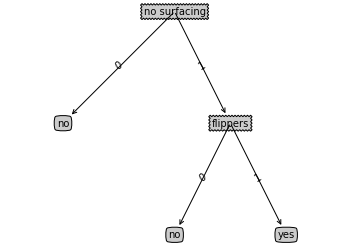

In [12]:
myData5, myFeatures5 = createDataSet()

print("My data was")
print(myData5, "\n")

print("My features were")
print(myFeatures5, "\n")

# construct decision tree with my data
myTree5 = createTree(myData5, myFeatures5)

# show me
print("My tree was")
print(myTree5, "\n")

# plot it
treePlotter.createPlot(myTree5)

Tree에 새로운 노드를 추가해봅시다. 어떻게 그려질까요?

My data was
[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']] 

My features were
['no surfacing', 'flippers'] 

My tree was
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}} 



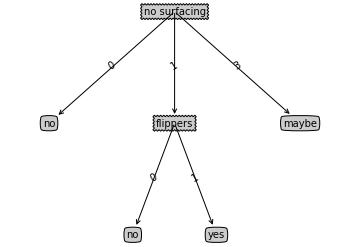

In [13]:
myData6, myFeatures6 = createDataSet()

print("My data was")
print(myData6, "\n")

print("My features were")
print(myFeatures6, "\n")

# construct decision tree with my data
myTree6 = createTree(myData6, myFeatures6)

#### create new node ####
myTree6['no surfacing'][3] = 'maybe'

# show me
print("My tree was")
print(myTree6, "\n")

# plot it
treePlotter.createPlot(myTree6)

## Decision Tree로 분류하기

이제 데이터셋이 주어지면 decision tree를 그릴 수 있게 되었는데요, 이를 이용하여 새로운 데이터를 분류해봐야겠죠?

만든 decision tree로 분류를 하는 <b>classify()</b> 함수를 작성합시다.

In [14]:
def classify(inputTree, featureNames, testVec):
    firstFeature = list(inputTree.keys())[0]
    subTreeDict = inputTree[firstFeature]
    
    featureIndex = featureNames.index(firstFeature)
    
    for key in subTreeDict.keys():
        if testVec[featureIndex] == key:
            if type(subTreeDict[key]).__name__ == "dict": # non-leaf node
                classLabel = classify(subTreeDict[key], featureNames, testVec)
            else: # leaf node
                classLabel = subTreeDict[key]
        
    return classLabel

테스트 해봅시다.

My data was
[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']] 

My features were
['no surfacing', 'flippers'] 



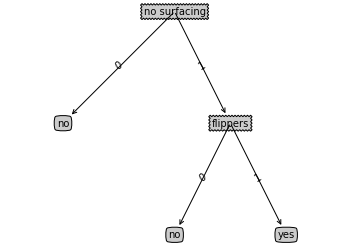

[1, 0] classified as no
[1, 1] classified as yes


In [15]:
myData7, myFeatures7 = createDataSet()

print("My data was")
print(myData7, "\n")

print("My features were")
print(myFeatures7, "\n")

# construct decision tree with my data
myTree7 = createTree(myData7, myFeatures7)

# plot it
treePlotter.createPlot(myTree7)

# test vectors
testVec0 = [1, 0] # no surfacing : Yes, filppers : no
testVec1 = [1, 1] # no surfacing : Yes, flippers : Yes

# classify
print(testVec0, "classified as", classify(myTree7, myFeatures7, testVec0))
print(testVec1, "classified as", classify(myTree7, myFeatures7, testVec1))

## 콘택트 렌즈 처방하기

<a href="./datasets/lenses.txt">Lenses 데이터셋</a>은 환자의 눈 상태에 따라 의사들이 어떤 콘택트 렌즈를 처방했는지에 대한 데이터셋입니다.

4개의 feature column, 1개의 label column으로 총 5개의 column으로 구성됩니다.

각각의 column은

1. age of the patient: (1) young, (2) pre-presbyopic(젊은 노안), (3) presbyopic(노안)
2. spectacle prescription: (1) myope(근시), (2) hypermetrope(원시)
3. astigmatic(난시): (1) no, (2) yes 
4. tear production rate: (1) reduced, (2) normal

을 나타내며, label로는 (1) no lenses, (2) soft, (3) hard 가 주어집니다.

차근차근 진행해봅시다. 먼저 데이터셋을 불러와야겠죠?

In [16]:
with open("./datasets/lenses.txt", "r") as inFile:
    lensesData = [line.strip().split("\t") for line in inFile.readlines()]

각각의 feature name은 데이터셋에 함께 제공되어있지 않으므로, 손으로 입력해줍시다.

In [17]:
lensesFeatures = ['age', 'prescript', 'astigmatic', 'tearRate']

Tree를 만듭니다.

In [18]:
lensesTree = createTree(lensesData, lensesFeatures)

print("Lenses tree looks like")
print(lensesTree)

Lenses tree looks like
{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft', 'young': 'soft', 'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}}}}, 'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses', 'young': 'hard', 'presbyopic': 'no lenses'}}, 'myope': 'hard'}}}}, 'reduced': 'no lenses'}}


뭔가 tree가 만들어진 것 같군요. 한눈에 알아보기가 어려우니 시각화하여 봅시다.

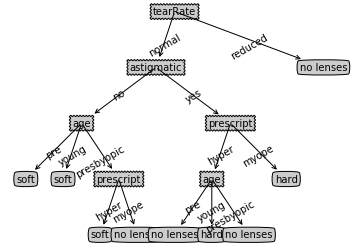

In [19]:
treePlotter.createPlot(lensesTree)

## 실습: 독버섯??

<a href="./datasets/mushroom.txt">Mushroom</a> 데이터셋은 버섯의 여러 가지 특징들을 관찰하여 먹을 수 있는 버섯인지, 아닌지 구별하기 위한 데이터셋입니다.

총 22개의 feature와 1개의 label(edible = e, poisonous = p)로 구성되어 있습니다.

Feature들은 아래와 같이 축약되어 있습니다.

1. cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s 
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s 
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y 
4. bruises?: bruises=t,no=f 
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s 
6. gill-attachment: attached=a,descending=d,free=f,notched=n 
7. gill-spacing: close=c,crowded=w,distant=d 
8. gill-size: broad=b,narrow=n 
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y 
10. stalk-shape: enlarging=e,tapering=t 
11. stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=? 
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s 
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s 
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
16. veil-type: partial=p,universal=u 
17. veil-color: brown=n,orange=o,white=w,yellow=y 
18. ring-number: none=n,one=o,two=t 
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z 
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y 
21. population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y 
22. habitat: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

※ 여러분들의 편의를 위해 데이터셋의 맨 첫줄은 tab으로 구분된 feature name들로 제공됩니다.

이 데이터셋을 가지고, 먹을수 있는 버섯과 독버섯을 어떤 feature들로 구분지을 수 있는지 알아보세요!